In [111]:
#export
from exp.nb_Tesis import *
path_to_2017_train_raw = Path('ISIC-2017_Training_Data/')
path_to_2018_train_raw = Path('ISIC2018_Task3_Training_Input/')
path_to_2019_train_raw = Path('ISIC_2019_Training_Input/')

path_to_2017_train_gt = Path('ISIC_2017_train_gt.csv')
path_to_2018_train_gt = Path('ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
path_to_2019_train_gt = Path('ISIC_2019_Training_GroundTruth.csv')

path_to_2018_test_raw = Path('ISIC2018_Task3_Test_Input/')
datasets = {
    '2017': {
        'train_images': path_to_2017_train_raw,
        'groundtruth': path_to_2017_train_gt
    },
    '2018': {
        'train_images': path_to_2018_train_raw,
        'groundtruth': path_to_2018_train_gt,
        'test_images': path_to_2018_test_raw
    },
    '2019': {
        'train_images': path_to_2019_train_raw,
        'groundtruth': path_to_2019_train_gt,
    }
}



In [112]:
#export

def resize_one(fn, i, path, size,path_hr):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BICUBIC).convert('RGB')
    img.save(dest, quality=100)

    
    
class DatasetManager:
    def __init__(self,year, dataset_type,min_image_size, amount_of_each_class ):
        self.year = year
        self.dataset_type=dataset_type
        self.min_image_size = min_image_size
        self.amount_of_each_class = amount_of_each_class
        self.classDict = {}
        self.df = pd.read_csv(datasets[year]['groundtruth'])
        
        image_col_name = 'image' if year != '2017' else 'image_id'
        print(image_col_name)
        self.dfSingleLabel = pd.DataFrame({'image':self.df[image_col_name] })
        labelcols = self.df.columns[1:len(self.df.columns)]
        self.dfSingleLabel['label'] = self.df[list(labelcols)].idxmax(axis='columns')
        
    def get_dataset_path(self):
        return Path(f'{self.year}_{self.dataset_type}_resized_to_{self.min_image_size}_picked_{self.amount_of_each_class}')

    def generate_dataset(self,force=False):
        if not self.year in ['2017','2018','2019']: raise Exception('We don\'t have a dataset for that year')
        if not self.dataset_type in ['train_images','test_images']: raise Exception('We don\'t have a dataset for that year')

        new_dataset_folder_name = self.get_dataset_path()
        original_images_path = datasets[self.year][self.dataset_type]
        list_of_original_images_paths = ImageList.from_folder(original_images_path).items
        
        if self.amount_of_each_class != 'all':
            print("Pruning the dataset")
            list_of_original_images_paths = self.prune_image_list(list_of_original_images_paths)
            print(len(list_of_original_images_paths))
        print('here')
        
        sets = [(new_dataset_folder_name, self.min_image_size)]
        for p,size in sets:
            if not p.exists():
                print(f"resizing to {size} into {p}")
                parallel(partial(resize_one, path=p, size=size, path_hr=original_images_path), list_of_original_images_paths)
                return new_dataset_folder_name
            else: 
                if force:
                    new_dataset_folder_name.rmdir()
                    parallel(partial(resize_one, path=p, size=size, path_hr=original_images_path), list_of_original_images_paths)
                    return new_dataset_folder_name
                else:
                    print(f'folder already exists: {new_dataset_folder_name}')
    
    
    def prune_image_list(self,image_list):
        return list(filter(self.should_image_be_included, image_list))
    
    
    def should_image_be_included(self, image_path):
        label = self.get_label_for_image_path(image_path)
        if label in self.classDict: self.classDict[label] = self.classDict[label] + 1
        else: self.classDict[label] = 1
#         print(self.classDict)
        if self.classDict[label] <= self.amount_of_each_class:
            return True
        else:
            return False
        
    def get_label_for_image_path(self,image_path):
        image_name = image_path.name[:-4]
        return list(self.dfSingleLabel.loc[self.dfSingleLabel['image']==image_name].label)[0]


In [105]:
dm = DatasetManager('2019','train_images',min_image_size=200,amount_of_each_class=10)

image


In [106]:
dm.generate_dataset(force=True)

Pruning the dataset
80
here
resizing to 200 into 2019_train_images_resized_to_200_picked_10


PosixPath('2019_train_images_resized_to_200_picked_10')

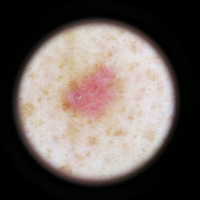

In [109]:
open_image(dm.get_dataset_path().ls()[1])

In [81]:
asd= Path('asd')

In [83]:
asd.rmdir()

FileNotFoundError: [Errno 2] No such file or directory: 'asd'